# Generative adversarial network

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transform
import matplotlib.pyplot as plt

%matplotlib inline

## 模型定义

### 判别器
利用线性层对输入进行线性变换，激活函数使用 `LeakyReLU`  
辨别器输入：形状为 \[batch_size, infeatures\] 的向量  
辨别器输出：得分

$LeakyRule(x) = \begin {cases} x, if x \ge 0 \\ negative\_slope \times x, otherwise \end{cases}$  
shape:  \[batch_size, in_features\]  $\Rightarrow$  \[batch_size, hidden_size\]  $\Rightarrow$  \[batch_size, hidden_size\]  $\Rightarrow$  \[batch_size, 1\]

In [117]:
class Discriminator(nn.Module):
    def __init__(self, in_features, hidden_size):
        super().__init__()
        self.fc = nn.Linear(1, 10)
        self.disc = nn.Sequential(
            nn.Linear(in_features+10, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, c):
        c = self.fc(c)
        x = torch.cat((x,c), 1)
        return self.disc(x)

### 生成器
利用线性层对输入进行线性变换，激活函数前两个线性层使用 `ReLU`，最后一层使用 `Tanh`    
生成器输入：形状为 \[batch_size, z_dim\] 的随机向量  
输出：形状为 \[batch_size, img_dim\] 的向量

$Tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$  
shape: \[batch_size, z_dim\]  $\Rightarrow$  \[batch_size, hidden_size\]  $\Rightarrow$  \[batch_size, hidden_size\]  $\Rightarrow$  \[batch_size, img_dim\]

In [118]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_size, img_dim):
        super().__init__()
        self.fc = nn.Linear(1, 10)
        self.gen = nn.Sequential(
            nn.Linear(z_dim+10, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, img_dim),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        c = self.fc(c)
        x = torch.cat((x,c), 1)
        return self.gen(x)

In [119]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
in_features = 784
hidden_size = 256
lr = 2e-4
z_dim = 100
img_dim = 28*28*1
batch_size = 256
num_epochs = 500

In [120]:
disc = Discriminator(in_features, hidden_size).to(device)
gen = Generator(z_dim, hidden_size, img_dim).to(device)

## 数据集准备
本次实验使用 `MNIST` 数据集  
transform 用于将图片转换为 tensor (形状：\[C, H, W\] (1,28,28)), 并对 tensor 进行归一化

In [121]:
fixed_noise = torch.randn((100, z_dim)).to(device)
l = [(i // 10) % 10 for i in range(100)]
label_ = torch.tensor(l).unsqueeze(1).float().to(device)
transform = transform.Compose(
    [transform.ToTensor(), transform.Normalize(mean=(0.5,), std=(0.5,))]
)

dataset = datasets.MNIST(root='dataset/mnist/', transform=transform, download=False)
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

## Optimizer 和Criterion
**BCELoss**  
$-\frac{1}{N}\sum^N_{i=1}y_ilog(x_i)+(1-y_i)log(1-x_i)$  
使用 `BCELoss` 的目的是让模型的分布接近于未知的真实分布，模型的优化目标是最大化训练数据的概率。

In [122]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

由于归一化后的图片张量的像素值在 \[-1, 1\] 之间，为了便于图片的可视乎，定义 `denorm()` 函数来实现反归一化。  
`save_fake_img()` 用于保存图片。

In [123]:
import os
# from IPython.display import Image
from torchvision.utils import save_image

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
def denorm(x):
    x = (x + 1) / 2
    return x.clamp(0, 1)

def save_fake_img(index):
    fake_images = gen(fixed_noise, label_)
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fname), nrow=10)

## 模型训练
### 判别器训练
1. 我们希望判别器对于真实图片输出 1，对生成的图片输出 0  
2. 首先向判别器输入一批真实图片，并计算 loss，该步的标签设置为 1
3. 接着，生成一批假图片输出到判别器， 并计算 loss， 该步的标签设置为 0
4. 最后，求两个 loss 的均值，利用梯度下降调整判别器的参数  

### 生成器训练
1. 我们使用生成器生成一批假图片，并传入判别器进行打分
2. 该步的标签设置为 1， 根据判别器的输出计算 loss
3. 根据上步的 loss 进行梯度下降调整生成器的参数

In [124]:
d_losses , g_losses = [], []
for epoch in range(num_epochs):
    for idx, (real, label) in  enumerate(loader):
        real = real.reshape(-1, 784).to(device)
        label = label.reshape(-1, 1).float().to(device)
        train_batch_size  = real.shape[0]
        
        noise = torch.randn((train_batch_size, z_dim)).to(device)
        fake = gen(noise, label)
        disc_real = disc(real, label).reshape(-1)
        lossD_real = criterion(disc_real,torch.ones_like(disc_real))
        disc_fake= disc(fake, label).reshape(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        opt_disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        output = disc(fake, label).reshape(-1)
        lossG = criterion(output, torch.ones_like(output))
        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        d_losses.append(lossD.item())
        g_losses.append(lossG.item())
        
        if (idx+1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{idx+1}/{len(loader)}], Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
            # with torch.no_grad():
            #    fake = gen(fixed_noise).reshape(-1, 1, 28, 28).cpu().numpy()
            #    plt.imshow(fake[0].reshape(28,28), cmap='gray')
            #    plt.show()
        
    save_fake_img(epoch+1)

Epoch [1/500], Step [100/235], Loss D: 0.0939, loss G: 3.6103
Epoch [1/500], Step [200/235], Loss D: 0.0100, loss G: 5.5337
Saving fake_images-0001.png
Epoch [2/500], Step [100/235], Loss D: 0.0355, loss G: 5.7126
Epoch [2/500], Step [200/235], Loss D: 0.0249, loss G: 7.1199
Saving fake_images-0002.png
Epoch [3/500], Step [100/235], Loss D: 0.0444, loss G: 5.7601
Epoch [3/500], Step [200/235], Loss D: 0.0735, loss G: 4.3900
Saving fake_images-0003.png
Epoch [4/500], Step [100/235], Loss D: 0.0636, loss G: 5.8125
Epoch [4/500], Step [200/235], Loss D: 0.1355, loss G: 5.3942
Saving fake_images-0004.png
Epoch [5/500], Step [100/235], Loss D: 0.0263, loss G: 6.7166
Epoch [5/500], Step [200/235], Loss D: 0.0473, loss G: 6.2093
Saving fake_images-0005.png
Epoch [6/500], Step [100/235], Loss D: 0.2589, loss G: 4.5390
Epoch [6/500], Step [200/235], Loss D: 0.0460, loss G: 6.8788
Saving fake_images-0006.png
Epoch [7/500], Step [100/235], Loss D: 0.0498, loss G: 6.3103
Epoch [7/500], Step [200/2

Epoch [54/500], Step [200/235], Loss D: 0.1592, loss G: 4.5250
Saving fake_images-0054.png
Epoch [55/500], Step [100/235], Loss D: 0.1335, loss G: 3.9860
Epoch [55/500], Step [200/235], Loss D: 0.1829, loss G: 5.7352
Saving fake_images-0055.png
Epoch [56/500], Step [100/235], Loss D: 0.1768, loss G: 4.0545
Epoch [56/500], Step [200/235], Loss D: 0.1565, loss G: 5.2874
Saving fake_images-0056.png
Epoch [57/500], Step [100/235], Loss D: 0.1485, loss G: 4.9235
Epoch [57/500], Step [200/235], Loss D: 0.1486, loss G: 3.9355
Saving fake_images-0057.png
Epoch [58/500], Step [100/235], Loss D: 0.1800, loss G: 3.8964
Epoch [58/500], Step [200/235], Loss D: 0.0934, loss G: 4.0955
Saving fake_images-0058.png
Epoch [59/500], Step [100/235], Loss D: 0.1010, loss G: 4.1598
Epoch [59/500], Step [200/235], Loss D: 0.1421, loss G: 4.7237
Saving fake_images-0059.png
Epoch [60/500], Step [100/235], Loss D: 0.1796, loss G: 3.5405
Epoch [60/500], Step [200/235], Loss D: 0.1266, loss G: 4.0991
Saving fake_i

Saving fake_images-0107.png
Epoch [108/500], Step [100/235], Loss D: 0.2527, loss G: 3.1228
Epoch [108/500], Step [200/235], Loss D: 0.1948, loss G: 3.4705
Saving fake_images-0108.png
Epoch [109/500], Step [100/235], Loss D: 0.2479, loss G: 2.7497
Epoch [109/500], Step [200/235], Loss D: 0.2708, loss G: 2.9849
Saving fake_images-0109.png
Epoch [110/500], Step [100/235], Loss D: 0.2339, loss G: 3.7575
Epoch [110/500], Step [200/235], Loss D: 0.3003, loss G: 3.0983
Saving fake_images-0110.png
Epoch [111/500], Step [100/235], Loss D: 0.2863, loss G: 2.9478
Epoch [111/500], Step [200/235], Loss D: 0.2735, loss G: 2.7679
Saving fake_images-0111.png
Epoch [112/500], Step [100/235], Loss D: 0.3664, loss G: 2.3797
Epoch [112/500], Step [200/235], Loss D: 0.3148, loss G: 2.5198
Saving fake_images-0112.png
Epoch [113/500], Step [100/235], Loss D: 0.2755, loss G: 2.8831
Epoch [113/500], Step [200/235], Loss D: 0.3065, loss G: 2.6422
Saving fake_images-0113.png
Epoch [114/500], Step [100/235], Los

Epoch [160/500], Step [200/235], Loss D: 0.3728, loss G: 2.3873
Saving fake_images-0160.png
Epoch [161/500], Step [100/235], Loss D: 0.3850, loss G: 2.6673
Epoch [161/500], Step [200/235], Loss D: 0.2688, loss G: 2.7898
Saving fake_images-0161.png
Epoch [162/500], Step [100/235], Loss D: 0.2954, loss G: 2.4395
Epoch [162/500], Step [200/235], Loss D: 0.3118, loss G: 2.4768
Saving fake_images-0162.png
Epoch [163/500], Step [100/235], Loss D: 0.3102, loss G: 2.7001
Epoch [163/500], Step [200/235], Loss D: 0.2962, loss G: 2.3750
Saving fake_images-0163.png
Epoch [164/500], Step [100/235], Loss D: 0.3286, loss G: 2.2203
Epoch [164/500], Step [200/235], Loss D: 0.3479, loss G: 2.4723
Saving fake_images-0164.png
Epoch [165/500], Step [100/235], Loss D: 0.3424, loss G: 3.0593
Epoch [165/500], Step [200/235], Loss D: 0.2684, loss G: 2.5962
Saving fake_images-0165.png
Epoch [166/500], Step [100/235], Loss D: 0.2862, loss G: 2.7883
Epoch [166/500], Step [200/235], Loss D: 0.4299, loss G: 2.8915


Epoch [213/500], Step [100/235], Loss D: 0.2772, loss G: 2.9461
Epoch [213/500], Step [200/235], Loss D: 0.3286, loss G: 2.0500
Saving fake_images-0213.png
Epoch [214/500], Step [100/235], Loss D: 0.3607, loss G: 2.7604
Epoch [214/500], Step [200/235], Loss D: 0.3381, loss G: 2.7662
Saving fake_images-0214.png
Epoch [215/500], Step [100/235], Loss D: 0.3526, loss G: 2.1035
Epoch [215/500], Step [200/235], Loss D: 0.3572, loss G: 2.3805
Saving fake_images-0215.png
Epoch [216/500], Step [100/235], Loss D: 0.3150, loss G: 2.4147
Epoch [216/500], Step [200/235], Loss D: 0.3066, loss G: 2.4528
Saving fake_images-0216.png
Epoch [217/500], Step [100/235], Loss D: 0.3352, loss G: 2.4741
Epoch [217/500], Step [200/235], Loss D: 0.2787, loss G: 2.3340
Saving fake_images-0217.png
Epoch [218/500], Step [100/235], Loss D: 0.3155, loss G: 2.6458
Epoch [218/500], Step [200/235], Loss D: 0.3318, loss G: 2.2020
Saving fake_images-0218.png
Epoch [219/500], Step [100/235], Loss D: 0.3616, loss G: 2.0013


Saving fake_images-0265.png
Epoch [266/500], Step [100/235], Loss D: 0.3064, loss G: 2.4174
Epoch [266/500], Step [200/235], Loss D: 0.3757, loss G: 1.8636
Saving fake_images-0266.png
Epoch [267/500], Step [100/235], Loss D: 0.3814, loss G: 2.1527
Epoch [267/500], Step [200/235], Loss D: 0.4284, loss G: 1.8401
Saving fake_images-0267.png
Epoch [268/500], Step [100/235], Loss D: 0.3628, loss G: 2.2019
Epoch [268/500], Step [200/235], Loss D: 0.3846, loss G: 2.0951
Saving fake_images-0268.png
Epoch [269/500], Step [100/235], Loss D: 0.4166, loss G: 1.8511
Epoch [269/500], Step [200/235], Loss D: 0.3872, loss G: 2.6104
Saving fake_images-0269.png
Epoch [270/500], Step [100/235], Loss D: 0.4797, loss G: 2.1880
Epoch [270/500], Step [200/235], Loss D: 0.3882, loss G: 2.0870
Saving fake_images-0270.png
Epoch [271/500], Step [100/235], Loss D: 0.4496, loss G: 1.5449
Epoch [271/500], Step [200/235], Loss D: 0.4454, loss G: 1.9870
Saving fake_images-0271.png
Epoch [272/500], Step [100/235], Los

Epoch [318/500], Step [200/235], Loss D: 0.4193, loss G: 2.1652
Saving fake_images-0318.png
Epoch [319/500], Step [100/235], Loss D: 0.4022, loss G: 2.1399
Epoch [319/500], Step [200/235], Loss D: 0.4638, loss G: 1.9124
Saving fake_images-0319.png
Epoch [320/500], Step [100/235], Loss D: 0.3719, loss G: 2.4104
Epoch [320/500], Step [200/235], Loss D: 0.3872, loss G: 2.2812
Saving fake_images-0320.png
Epoch [321/500], Step [100/235], Loss D: 0.4212, loss G: 1.7960
Epoch [321/500], Step [200/235], Loss D: 0.3558, loss G: 2.0256
Saving fake_images-0321.png
Epoch [322/500], Step [100/235], Loss D: 0.4636, loss G: 2.0054
Epoch [322/500], Step [200/235], Loss D: 0.4640, loss G: 1.6125
Saving fake_images-0322.png
Epoch [323/500], Step [100/235], Loss D: 0.3746, loss G: 2.3419
Epoch [323/500], Step [200/235], Loss D: 0.3865, loss G: 2.3252
Saving fake_images-0323.png
Epoch [324/500], Step [100/235], Loss D: 0.4590, loss G: 1.6677
Epoch [324/500], Step [200/235], Loss D: 0.3071, loss G: 2.2502


Epoch [371/500], Step [100/235], Loss D: 0.3519, loss G: 1.9579
Epoch [371/500], Step [200/235], Loss D: 0.4222, loss G: 2.0375
Saving fake_images-0371.png
Epoch [372/500], Step [100/235], Loss D: 0.3960, loss G: 2.0852
Epoch [372/500], Step [200/235], Loss D: 0.3822, loss G: 2.1146
Saving fake_images-0372.png
Epoch [373/500], Step [100/235], Loss D: 0.3825, loss G: 1.7933
Epoch [373/500], Step [200/235], Loss D: 0.4579, loss G: 2.3616
Saving fake_images-0373.png
Epoch [374/500], Step [100/235], Loss D: 0.3798, loss G: 2.0600
Epoch [374/500], Step [200/235], Loss D: 0.3527, loss G: 2.1138
Saving fake_images-0374.png
Epoch [375/500], Step [100/235], Loss D: 0.4628, loss G: 1.7868
Epoch [375/500], Step [200/235], Loss D: 0.4689, loss G: 1.6299
Saving fake_images-0375.png
Epoch [376/500], Step [100/235], Loss D: 0.4223, loss G: 1.8499
Epoch [376/500], Step [200/235], Loss D: 0.4859, loss G: 1.7286
Saving fake_images-0376.png
Epoch [377/500], Step [100/235], Loss D: 0.4752, loss G: 1.7896


Saving fake_images-0423.png
Epoch [424/500], Step [100/235], Loss D: 0.4111, loss G: 1.7863
Epoch [424/500], Step [200/235], Loss D: 0.3827, loss G: 1.7862
Saving fake_images-0424.png
Epoch [425/500], Step [100/235], Loss D: 0.4810, loss G: 1.7305
Epoch [425/500], Step [200/235], Loss D: 0.3827, loss G: 1.7876
Saving fake_images-0425.png
Epoch [426/500], Step [100/235], Loss D: 0.4443, loss G: 1.8765
Epoch [426/500], Step [200/235], Loss D: 0.3731, loss G: 1.8756
Saving fake_images-0426.png
Epoch [427/500], Step [100/235], Loss D: 0.4822, loss G: 1.7249
Epoch [427/500], Step [200/235], Loss D: 0.4116, loss G: 2.5466
Saving fake_images-0427.png
Epoch [428/500], Step [100/235], Loss D: 0.4645, loss G: 1.7385
Epoch [428/500], Step [200/235], Loss D: 0.4522, loss G: 1.8424
Saving fake_images-0428.png
Epoch [429/500], Step [100/235], Loss D: 0.3798, loss G: 1.9371
Epoch [429/500], Step [200/235], Loss D: 0.4432, loss G: 1.7592
Saving fake_images-0429.png
Epoch [430/500], Step [100/235], Los

Epoch [476/500], Step [200/235], Loss D: 0.5471, loss G: 1.2091
Saving fake_images-0476.png
Epoch [477/500], Step [100/235], Loss D: 0.4287, loss G: 1.6533
Epoch [477/500], Step [200/235], Loss D: 0.4729, loss G: 1.3469
Saving fake_images-0477.png
Epoch [478/500], Step [100/235], Loss D: 0.4303, loss G: 1.7287
Epoch [478/500], Step [200/235], Loss D: 0.5277, loss G: 1.5553
Saving fake_images-0478.png
Epoch [479/500], Step [100/235], Loss D: 0.4264, loss G: 1.5507
Epoch [479/500], Step [200/235], Loss D: 0.4361, loss G: 1.5995
Saving fake_images-0479.png
Epoch [480/500], Step [100/235], Loss D: 0.4495, loss G: 1.7793
Epoch [480/500], Step [200/235], Loss D: 0.4753, loss G: 1.8041
Saving fake_images-0480.png
Epoch [481/500], Step [100/235], Loss D: 0.4622, loss G: 1.5834
Epoch [481/500], Step [200/235], Loss D: 0.5062, loss G: 1.7504
Saving fake_images-0481.png
Epoch [482/500], Step [100/235], Loss D: 0.4544, loss G: 1.9347
Epoch [482/500], Step [200/235], Loss D: 0.5067, loss G: 1.3141


In [125]:
torch.save(disc.state_dict(), 'D.ckpt')
torch.save(gen.state_dict(), 'G.ckpt')

Text(0.5, 1.0, 'Losses')

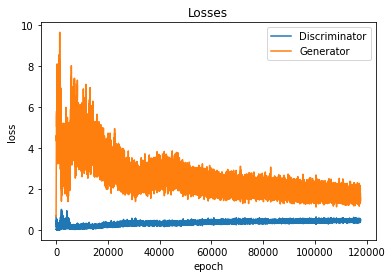

In [126]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [127]:
from IPython.display import Image

## 加载模型参数

In [128]:
# disc.load_state_dict(torch.load('D.ckpt'))
# disc.eval()
# gen.load_state_dict(torch.load('G.ckpt'))
# gen.eval()

# print(disc)
# print()
# print(gen)

## 测试生成器效果

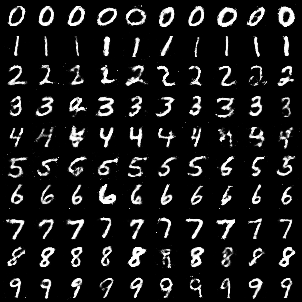

In [129]:
randn_noise = torch.randn((100, z_dim)).to(device)
fake = gen(randn_noise, label_).reshape(-1, 1, 28, 28)
save_image(denorm(fake),os.path.join(sample_dir, 'test_result.png'), nrow = 10)

Image(os.path.join(sample_dir, 'test_result.png'))

In [130]:
# !pip install opencv-python

In [131]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in  f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MJPG'), 8, (302, 302))
[out.write(cv2.imread(fname)) for fname in  files]
out.release()
FileLink('gans_training.avi')


C:\Users\Caden\pytorch_learning_from_scratch\gans_training.avi